<span style="font-size:10pt">Copyright Jean-Luc CHARLES $-$ 2025/03/14 $-$ CC BY-SA 4.0 $-$  <img src="img/CC-BY-SA.jpeg" width="50"></span> 

# Training Reproducibility with tensorflow

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
    It is fundamental to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for each important Python project: the PVE makes it possible to control for each project the versions of the Python interpreter and "sensitive" modules (like tensorflow for example).</span></div>

This notebook should be run with tensorflow 2.16.2

## 1 - Import the required Python modules

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #suppress the numerous TensorFlow warnings

import tensorflow as tf
from tensorflow import keras

import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
from time import time
from cpuinfo import get_cpu_info

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# specific modules:
from utils.tools import scan_dir, plot_images, plot_loss_accuracy, elapsed_time_since, show_conf_matrix, plot_proportion_bar

print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} with keras {keras.__version__}")
print(f"numpy     : {np.__version__}")
print(f"OpenCV    : {cv2.__version__}")

Python    : 3.12.3
tensorflow: 2.16.2 with keras 3.8.0
numpy     : 1.26.4
OpenCV    : 4.11.0


In [2]:
# allows to visualize the graphs directly in the cell of the notebook:
%matplotlib inline

Set the seed if needed, for all the random generators:

In [3]:
SEED = 1234

## 2 - Load the MNIST dataset (images and labels)

We use the keras `load_data` function to load the data from the MNIST 
(see [tf.keras.datasets.mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data)):<br>
- `im_train`, `lab_train` are the training images and labels,
- `im_valid`, `lab_valid` are the validation images and labels.

In [4]:
(im_train, lab_train), (im_valid, lab_valid) = keras.datasets.mnist.load_data()

Let's check the `shape` and `dtype` attributes of the numpy arrays:

In [5]:
print(f"im_train.shape:  {im_train.shape}, dtype: {im_train.dtype}")
print(f"im_valid.shape:  {im_valid.shape}, dtype: {im_valid.dtype}")
print(f"lab_train.shape: {lab_train.shape}, dtype: {lab_train.dtype}")
print(f"lab_vaild.shape: {lab_valid.shape}, dtype: {lab_valid.dtype}")

im_train.shape:  (60000, 28, 28), dtype: uint8
im_valid.shape:  (10000, 28, 28), dtype: uint8
lab_train.shape: (60000,), dtype: uint8
lab_vaild.shape: (10000,), dtype: uint8


### Reduce the size of the dataset

For demonstration purposes, we will truncate the input arrays to 1/10 of the initial sizes:

In [6]:
im_train  = im_train[:6000]
lab_train = lab_train[:6000]
im_valid  = im_valid[:1000]
lab_valid = lab_valid[:1000]

print("im_train.shape :", im_train.shape, ", lab_train.shape:", lab_train.shape)
print("im_valid.shape :", im_valid.shape, ", lab_valid.shape:", lab_valid.shape)

im_train.shape : (6000, 28, 28) , lab_train.shape: (6000,)
im_valid.shape : (1000, 28, 28) , lab_valid.shape: (1000,)


### Visualization of images and labels:

The local module `utils.tools` defines the `plot_images` function which can be used to diplay a grid of MINIT images.<br>
Let's plot a grid of images 4 x 6 geginning with the 600th image:

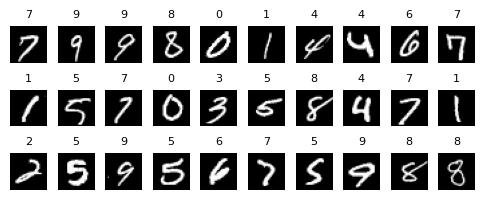

In [7]:
plot_images(im_train, 3, 10, 599, label_array=lab_train)

### Create the 3 datasets: tain, validation & test

To follow the _state of the art_, we will split the whole dataset into train, validation & test datasets.<br>
A simple way to do this is to keep the train dataset and to split of the current validation dataset in two equal subsets:
- a new smaller validation set,
- a new test set.

In [8]:
# note on train_test_split : Stratified train/test split is not implemented for shuffle=False 

im_valid, im_test, lab_valid, lab_test = train_test_split(im_valid, lab_valid,
                                                          stratify=lab_valid,
                                                          test_size=0.5,
                                                          shuffle=True,
                                                          random_state=SEED)

We can verify that the proportion of digits remains homogenous in all the datasets:

In [9]:
prop = {}
prop['valid'] = [ (lab_valid == i).sum() for i in range(10)]
prop['test']  = [ (lab_test  == i).sum() for i in range(10)]

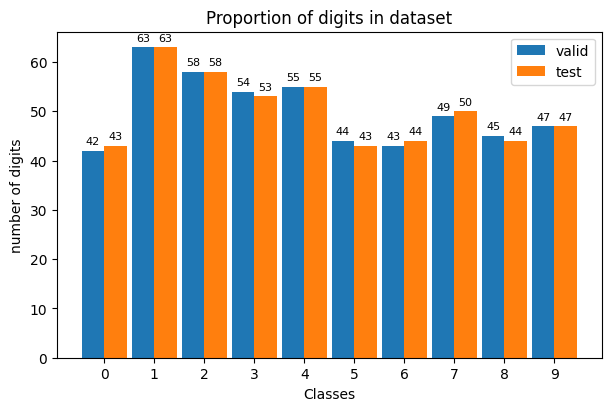

In [10]:
plot_proportion_bar(prop, range(10))

### Setting useful parameters:

To avoid hard-coding the number of training and test images as well as the size of the images, these parameters are recovered from the data set:
- with the shape attribute of the image arrays
- with the size attribute of the first training image for example

In [37]:
# number of training images:
NB_IM_TRAIN = im_train.shape[0]
NB_IM_VALID = im_valid.shape[0]     
NB_IM_TEST  = im_test.shape[0]     

# number of classes:
NB_CLASS = len(set(lab_train))
print(f"{NB_CLASS} different classes found in the `lab_train` ndarray")

10 different classes found in the `lab_train` ndarray


## 3 - Pre-process input dataset

### Reshape the data arrays to fit keras requirements

The convolutional layers of **keras** take by default arrays of shape `(batch_size, height, width, depth)` :
- `batch_size` : umber of images in a batch of input date,
- `height` et `width` : the size of the images in pixels,
- `depth` : color dimension (`3` for a RGB image, `1` for a grey tone image).

The current shapes of the input arrays ares :

In [38]:
im_train.shape, im_valid.shape, im_test.shape

((6000, 28, 28), (500, 28, 28), (500, 28, 28))

We must add the dimension `depth` (value: 1 for grey tone images) after the third dimension `width`, for example using the method `reshape` of the class `ndarray`.<br>
We also normalize the input arrays so that their elements are in [0, 1]. 

In [41]:
x_train = im_train.reshape(im_train.shape + (1,))/255
x_valid = im_valid.reshape(im_valid.shape + (1,))/255
x_test  = im_test.reshape(im_test.shape + (1,))/255

# check:
print(f'train:  {im_train.shape} -> {x_train.shape},  min: {x_train.min()}, max: {x_train.max()}')
print(f'valid:  {im_valid.shape} -> {x_valid.shape},  min: {x_valid.min()}, max: {x_valid.max()}')
print(f'test :  {im_test.shape}  -> {x_test.shape},  min: {x_test.min()}, max: {x_test.max()}')

# image shape:
IM_SHAPE = x_train[0].shape

# Visual checking:
print(f"Image size: {IM_SHAPE}")

train:  (6000, 28, 28) -> (6000, 28, 28, 1),  min: 0.0, max: 1.0
valid:  (500, 28, 28) -> (500, 28, 28, 1),  min: 0.0, max: 1.0
test :  (500, 28, 28)  -> (500, 28, 28, 1),  min: 0.0, max: 1.0
Image size: (28, 28, 1)


### *one-hot* encoding of the label arrays:

We use the **keras** `to_categorical` function (see [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)) to define the `y_train`, `y_valid` and `y_test` arrays containing the *hot-one* encoded version of `lab_train`, `lab_valid` and `lab_test`:

In [42]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' of labels :
y_train = to_categorical(lab_train)
y_valid = to_categorical(lab_valid)
y_test  = to_categorical(lab_test)

Let's check the first 10 values of the `lab_train` and `y_train` arrays:

In [43]:
print(lab_train[:10])
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## 4 - Build the Convolutional Neural Network (CNN)

We build a CNN similar to __LeNet5__ introduced in the research paper “Gradient-Based Learning Applied To Document Recognition” in 1998 by Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffnerfrom.

![img/LeNet5.png](img/LeNet5.png)

In the rest of this notebook, we will build the CNN many times so we define the function `build_CNN`:

In [46]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, AveragePooling2D, MaxPool2D, Flatten

def build_CNN(input_shape, seed=None):

    if seed != None:
        # Deterministic tensorflow training: 
        # 1/ set the seed of the random generators involved with tensorflow:
        tf.keras.utils.set_random_seed(seed)
        # 2/ make the tf aps determinisctic 
        # [see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html]
        tf.config.experimental.enable_op_determinism()         
    
    model = Sequential(name='LeNet5')
    
    # A layer to give the 4 dimensions of the input data:
    model.add(Input(shape=input_shape))
    
    # Layer C1: 6 convolution filters of 5x5 with padding and 'relu' activation function:
    model.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), padding='same', activation='tanh', name='C1'))
    
    # Layer S2: 'maximum' poolling stage, with 2x2:
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='S2'))
    
    # Layer C3: 16 convolution filters of 5x5 with padding and 'relu' activation function:
    model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), padding='valid', activation='tanh', name='C3'))
    
    # Layer S4: 'maximum' poolling stage, with 2x2:
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='S4'))
    
    # Flatten the images into a single vector with all the pixels:
    model.add(Flatten())

    # Layer C5: dense layer with 120 neurons and 'relu' activation function:
    model.add(Dense(120, activation='tanh', name='C5'))
    
    # F6: dense layer with 84 neurones and 'relu' activation function:
    model.add(Dense(84, activation='tanh', name='F6'))
    
    # Output: final dense layer, with 'NB_CLASS'(10) neutones and the 'softmax' 
    # activation function dedicated to classification training:
    model.add(Dense(NB_CLASS, activation='softmax', name='Output'))    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [48]:
model = build_CNN(IM_SHAPE)
model.summary()

Model: "LeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                     │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S2 (MaxPooling2D)               │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C3 (Conv2D)                     │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S4 (MaxPooling2D)               │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C5 (Dense)                      │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ F6 (Dense)                      │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

## 5 - Reproducibilty of the DNN training...

#### A/ If we don't set the tensorflow seed, the training is not reproducible:

In the cell bellow, we train the network on only 1 epoch 5 times on a row:

In [88]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_CNN(IM_SHAPE)  # Build a new model without setting seed
    hist = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
188/188 - 1s - 7ms/step - accuracy: 0.8470 - loss: 0.5650 - val_accuracy: 0.9140 - val_loss: 0.2578
188/188 - 1s - 6ms/step - accuracy: 0.8347 - loss: 0.5792 - val_accuracy: 0.8960 - val_loss: 0.3095
188/188 - 1s - 6ms/step - accuracy: 0.8443 - loss: 0.5606 - val_accuracy: 0.9060 - val_loss: 0.2785
188/188 - 1s - 6ms/step - accuracy: 0.8302 - loss: 0.5984 - val_accuracy: 0.8800 - val_loss: 0.3643
188/188 - 1s - 6ms/step - accuracy: 0.8382 - loss: 0.5611 - val_accuracy: 0.8760 - val_loss: 0.3519


In [89]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_CNN(IM_SHAPE)  # Build a new model without setting seed
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
375/375 - 1s - 4ms/step - accuracy: 0.8683 - loss: 0.4564 - val_accuracy: 0.9140 - val_loss: 0.2543
375/375 - 1s - 4ms/step - accuracy: 0.8760 - loss: 0.4384 - val_accuracy: 0.9340 - val_loss: 0.2268
375/375 - 2s - 4ms/step - accuracy: 0.8713 - loss: 0.4544 - val_accuracy: 0.9140 - val_loss: 0.2652
375/375 - 1s - 4ms/step - accuracy: 0.8702 - loss: 0.4506 - val_accuracy: 0.9260 - val_loss: 0.2307
375/375 - 1s - 4ms/step - accuracy: 0.8752 - loss: 0.4354 - val_accuracy: 0.9200 - val_loss: 0.2241


In [90]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_CNN(IM_SHAPE)  # Build a new model without setting seed
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=16, 
                     validation_data=(x_valid[:200], y_valid[:200]), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
63/63 - 1s - 18ms/step - accuracy: 0.6670 - loss: 1.1455 - val_accuracy: 0.8550 - val_loss: 0.5299
63/63 - 1s - 17ms/step - accuracy: 0.6770 - loss: 1.1219 - val_accuracy: 0.8800 - val_loss: 0.5294
63/63 - 1s - 15ms/step - accuracy: 0.6460 - loss: 1.2249 - val_accuracy: 0.7750 - val_loss: 0.6919
63/63 - 1s - 22ms/step - accuracy: 0.6240 - loss: 1.2480 - val_accuracy: 0.8100 - val_loss: 0.6744
63/63 - 1s - 16ms/step - accuracy: 0.6600 - loss: 1.1628 - val_accuracy: 0.7950 - val_loss: 0.5988


In [91]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_CNN(IM_SHAPE)  # Build a new model without setting seed
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=32, 
                     validation_data=(x_valid[:200], y_valid[:200]), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
32/32 - 1s - 31ms/step - accuracy: 0.5890 - loss: 1.5017 - val_accuracy: 0.7450 - val_loss: 0.8556
32/32 - 1s - 30ms/step - accuracy: 0.5640 - loss: 1.6576 - val_accuracy: 0.7150 - val_loss: 0.9627
32/32 - 1s - 30ms/step - accuracy: 0.5640 - loss: 1.4766 - val_accuracy: 0.7400 - val_loss: 0.8401
32/32 - 1s - 29ms/step - accuracy: 0.5870 - loss: 1.4762 - val_accuracy: 0.7600 - val_loss: 0.8944
32/32 - 1s - 28ms/step - accuracy: 0.5180 - loss: 1.6320 - val_accuracy: 0.6850 - val_loss: 1.0248


#### B/ If we just reload the inital network the training is not reproducible:

In [84]:
model = build_CNN(IM_SHAPE)
model.save_weights('weights/CNN_tanh_noseed.weights.h5')

In [85]:
print(get_cpu_info()['brand_raw'])
model = build_CNN(IM_SHAPE)
for _ in range(5):
    model.load_weights('weights/CNN_tanh_noseed.weights.h5') # reload the inital model weights
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
375/375 - 2s - 4ms/step - accuracy: 0.8667 - loss: 0.4671 - val_accuracy: 0.9280 - val_loss: 0.2494
375/375 - 1s - 2ms/step - accuracy: 0.8568 - loss: 0.4859 - val_accuracy: 0.9320 - val_loss: 0.2399
375/375 - 1s - 2ms/step - accuracy: 0.8600 - loss: 0.4810 - val_accuracy: 0.9320 - val_loss: 0.2353
375/375 - 1s - 2ms/step - accuracy: 0.8585 - loss: 0.4806 - val_accuracy: 0.9340 - val_loss: 0.2356
375/375 - 1s - 2ms/step - accuracy: 0.8592 - loss: 0.4800 - val_accuracy: 0.9340 - val_loss: 0.2359


In [86]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model.load_weights('weights/CNN_tanh_noseed.weights.h5') # reload the inital model weights
    hist = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
188/188 - 1s - 5ms/step - accuracy: 0.8083 - loss: 0.6717 - val_accuracy: 0.8860 - val_loss: 0.3523
188/188 - 1s - 3ms/step - accuracy: 0.8097 - loss: 0.6556 - val_accuracy: 0.8940 - val_loss: 0.3393
188/188 - 0s - 3ms/step - accuracy: 0.8138 - loss: 0.6474 - val_accuracy: 0.8960 - val_loss: 0.3356
188/188 - 0s - 2ms/step - accuracy: 0.8148 - loss: 0.6418 - val_accuracy: 0.8980 - val_loss: 0.3324
188/188 - 0s - 3ms/step - accuracy: 0.8153 - loss: 0.6362 - val_accuracy: 0.8980 - val_loss: 0.3274


#### C/ If the tensorflow seed is set fthe training is reproducible:

In [73]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_CNN(IM_SHAPE, seed=1234)
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
375/375 - 2s - 4ms/step - accuracy: 0.8607 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2206
375/375 - 2s - 4ms/step - accuracy: 0.8607 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2206
375/375 - 2s - 4ms/step - accuracy: 0.8607 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2206
375/375 - 2s - 4ms/step - accuracy: 0.8607 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2206
375/375 - 2s - 4ms/step - accuracy: 0.8607 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2206


#### D/ If we load the models's structure & initial weights the training is reproducible

In [67]:
model = build_CNN(IM_SHAPE, seed=1234)
model.save('models/CNN_tanh_seed1234.keras')

In [68]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = tf.keras.models.load_model('models/CNN_tanh_seed1234.keras') # reload the model structure & weights 
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz


/home/jlc/work/IA-MachineLearning/16-Limoges-IRCEFR/Studies/Reproductibility-MNIST-CNN-GPU/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


375/375 - 1s - 4ms/step - accuracy: 0.8607 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2206
375/375 - 1s - 4ms/step - accuracy: 0.8607 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2206
375/375 - 1s - 3ms/step - accuracy: 0.8607 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2206
375/375 - 1s - 4ms/step - accuracy: 0.8607 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2206
375/375 - 1s - 4ms/step - accuracy: 0.8607 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2206


### A first training... to see

In [50]:
print(f'{IM_SHAPE=}')
print(f'{NB_CLASS=}')

IM_SHAPE=(28, 28, 1)
NB_CLASS=10


Elapsed time 7s -> 00:00:07


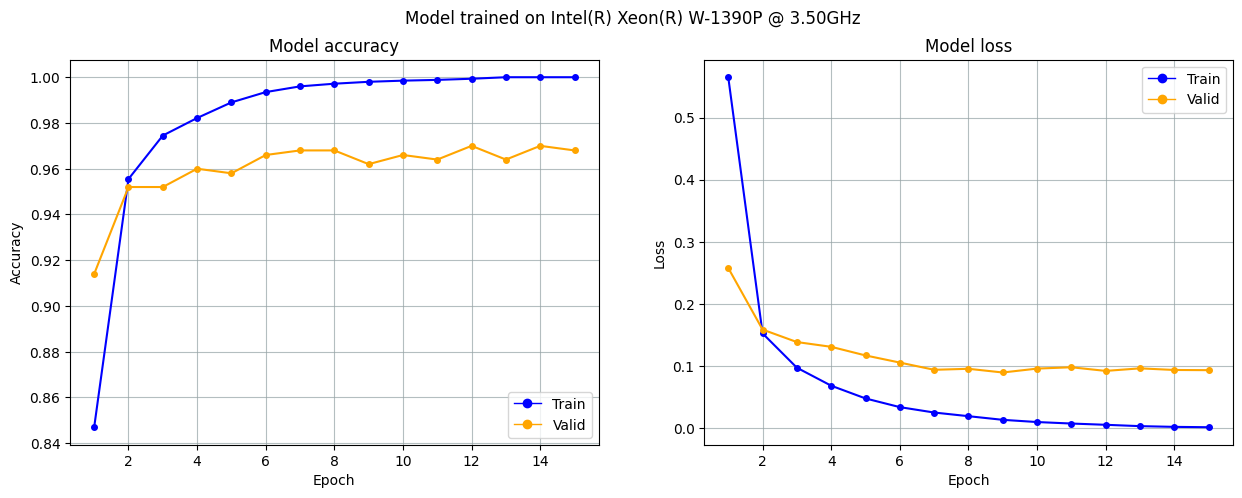

In [52]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=15,       # the total number of successive trainings
                 batch_size=32,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid), verbose=0)
print(elapsed_time_since(t0))
plot_loss_accuracy(hist)   

### Retry the training : non reproducibility revealed

Elapsed time 7s -> 00:00:07


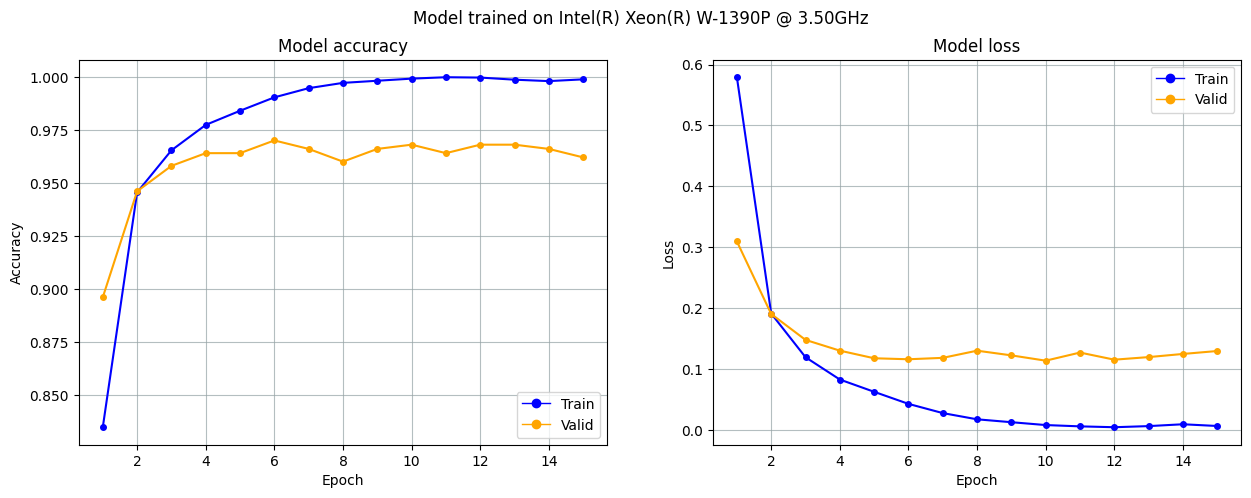

In [53]:
model = build_CNN(x_train[0].shape)
t0 = time()
hist = model.fit(x_train, y_train,
                 epochs=15,       # the total number of successive trainings
                 batch_size=32,  # fragmentation of the whole dada set in batches
                 validation_data=(x_valid, y_valid), verbose=0)
print(elapsed_time_since(t0))
plot_loss_accuracy(hist)   

### Running several identical trainings to compare their _Validation loss_ curves

Trainning #1 #2 #3 #4 #5 Total Train Elapsed time 37s -> 00:00:37


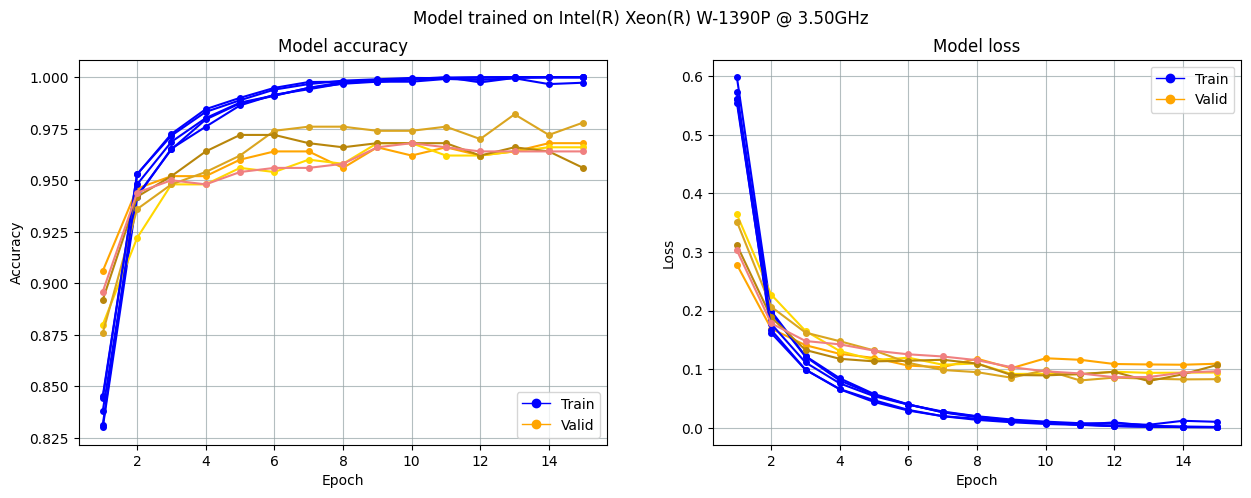

In [54]:
H, t0  = [], time()
print('Trainning', end='')

for i in range(5):
    print(f' #{i+1}', end='')
    
    # Build a new model at each lopp lap, without setting the tf seed:
    model = build_CNN(x_train[0].shape, seed=None)
        
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=15,        # the total number of successive trainings
                     batch_size=32,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  
    
print(f' Total Train {elapsed_time_since(t0)}')    
plot_loss_accuracy(H)   

### Running several identical training with __reproducibility setting validated__

Now we will try the same training but with setting the SEDD

Using: "tf.keras.utils.set_random_seed(1234)" and "tf.config.experimental.enable_op_determinism()"
to ensure training reproducibility

 #2 #3 #4 #5 Total Train Elapsed time 38s -> 00:00:38


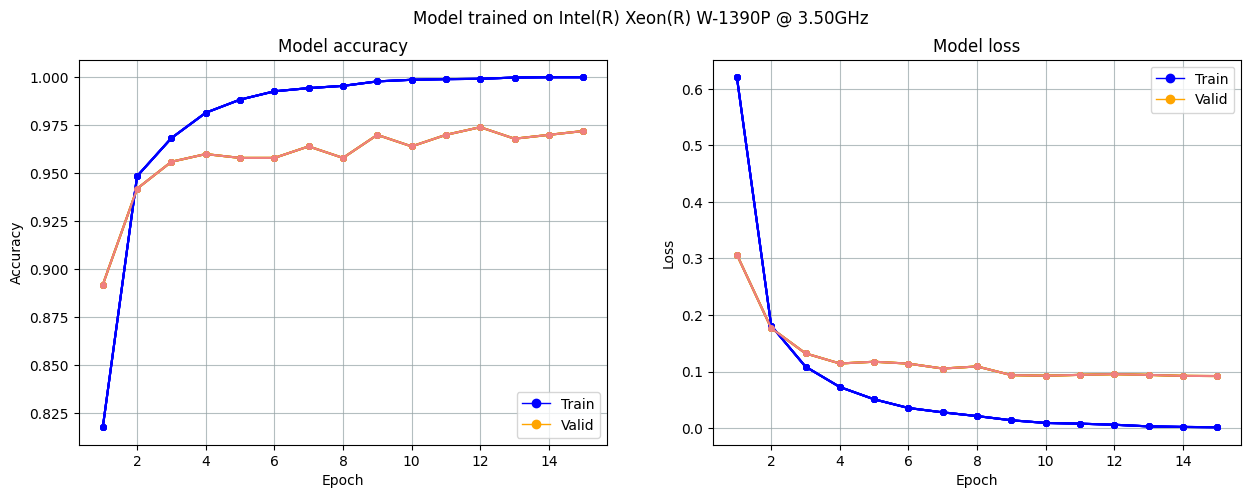

In [56]:
print(f'Using: "tf.keras.utils.set_random_seed({SEED})" and "tf.config.experimental.enable_op_determinism()"\nto ensure training reproducibility\n')

H, t0  = [], time()
print('Trainning', end='')

for i in range(5):
    print(f' #{i+1}', end='')
    
    # Build a new model at each lopp lap, with setting the tf seed:
    model = build_CNN(x_train[0].shape, seed=SEED)
        
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=15,        # the total number of successive trainings
                     batch_size=32,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  
    
print(f' Total Train {elapsed_time_since(t0)}')    
plot_loss_accuracy(H)   

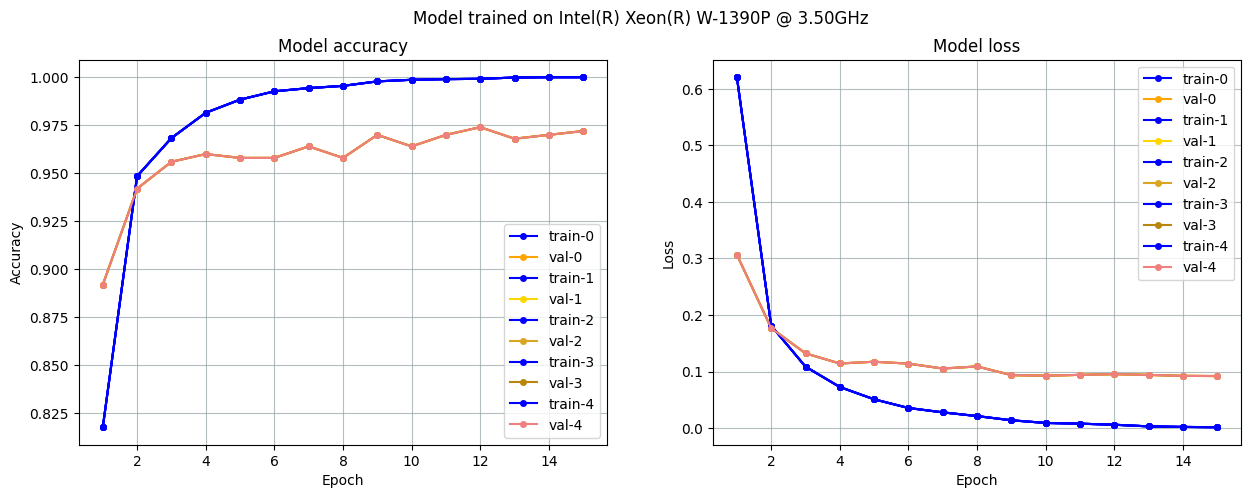

In [57]:
plot_loss_accuracy(H, single_legend=False)  

In [58]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Predicting labels for test images
predict_labels = np.argmax(model.predict(x_test), axis=-1)

# Display classification report
print("Classification Report:\n", classification_report(np.argmax(y_test, axis=-1), predict_labels))

16/16 - 0s - 3ms/step - accuracy: 0.9840 - loss: 0.0722
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       1.00      0.98      0.99        63
           2       0.97      0.97      0.97        58
           3       1.00      1.00      1.00        53
           4       1.00      0.95      0.97        55
           5       1.00      1.00      1.00        43
           6       1.00      0.98      0.99        44
           7       0.96      1.00      0.98        50
           8       0.98      0.98      0.98        44
           9       0.96      1.00      0.98        47

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



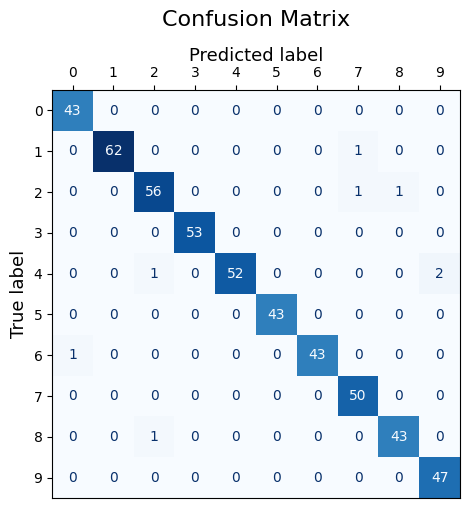

In [59]:
show_conf_matrix(lab_test, predict_labels, range(NB_CLASS), figsize=(7,6))

### Running several identical training with reloading the initial state

Another way to ensure reproductibility is to reload the model structure and initial weights at each run:

Trainning #1

/home/jlc/work/IA-MachineLearning/16-Limoges-IRCEFR/Studies/Reproductibility-MNIST-CNN-GPU/.venv/lib/python3.12/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(
/home/jlc/work/IA-MachineLearning/16-Limoges-IRCEFR/Studies/Reproductibility-MNIST-CNN-GPU/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 #2 #3 #4 #5 Total Train Elapsed time 7s -> 00:00:07


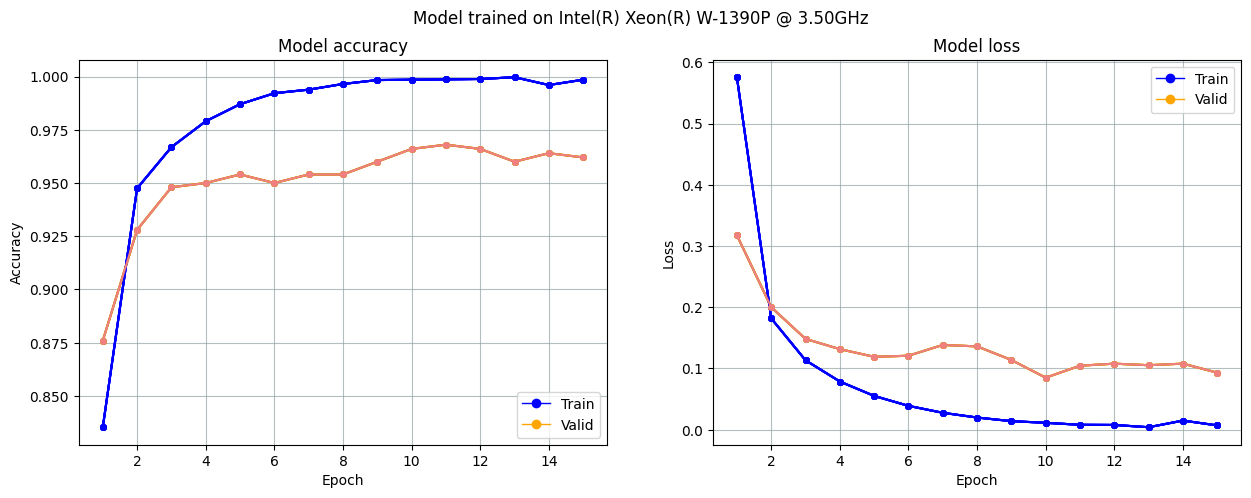

In [60]:
# Deterministic tensorflow training: 
# 1/ set the seed of the random generators involved with tensorflow:
tf.keras.utils.set_random_seed(SEED)
# 2/ make the tf aps determinisctic 
# [see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html]
tf.config.experimental.enable_op_determinism()        

H, t0  = [], time()
print('Trainning', end='')

# the structure and the initial waights of the CNN to be used:
model_file = 'CNN_tanh_noseed.keras'

for i in range(5):
    print(f' #{i+1}', end='')
    
    # load the network structure & initial weights:
    model = tf.keras.models.load_model('models/' + model_file)
        
    t0 = time()
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=15,        # the total number of successive trainings
                     batch_size=32,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  
    
print(f' Total Train {elapsed_time_since(t0)}')    
plot_loss_accuracy(H)   

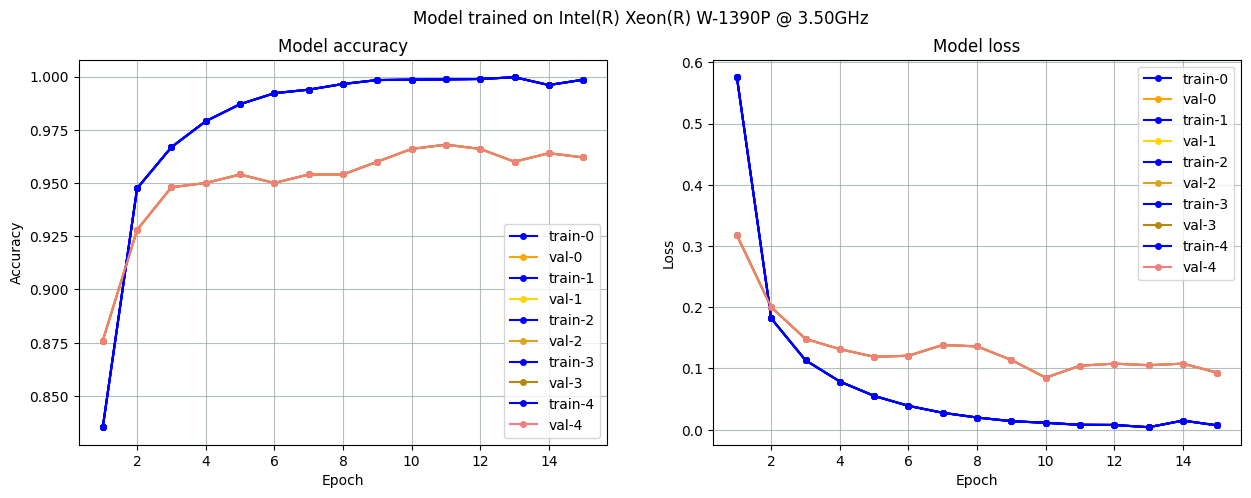

In [61]:
plot_loss_accuracy(H, single_legend=False)  

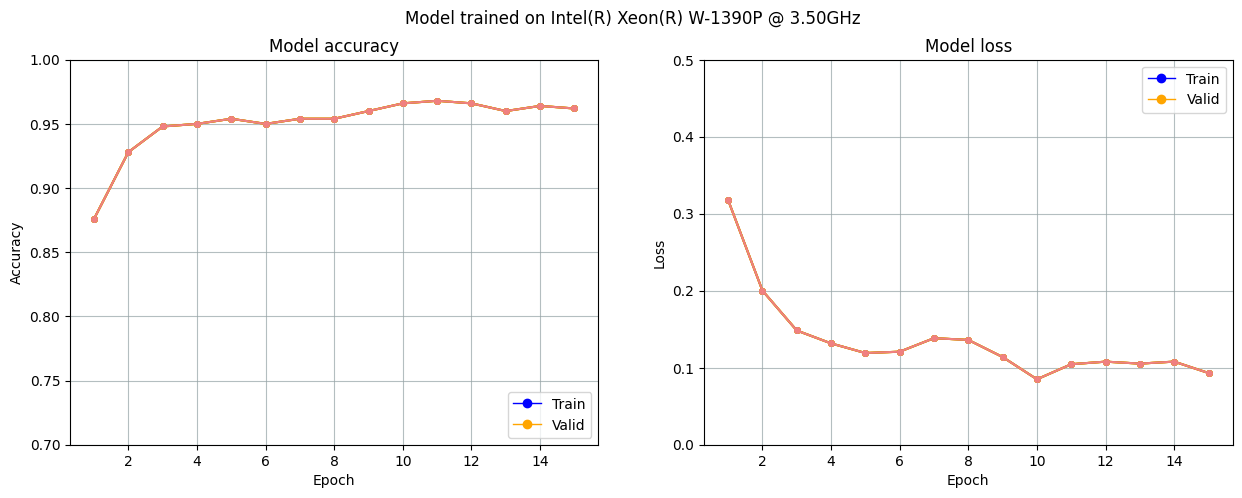

In [63]:
plot_loss_accuracy(H, training=False, min_acc=0.7,max_acc=1, min_loss=0, max_loss=.5,  max_epoch=15)   

In [64]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Predicting labels for test images
predict_labels = np.argmax(model.predict(x_test), axis=-1)

# Display classification report
print("Classification Report:\n", classification_report(np.argmax(y_test, axis=-1), predict_labels))

16/16 - 0s - 4ms/step - accuracy: 0.9700 - loss: 0.0853
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       0.98      0.98      0.98        63
           2       0.98      0.95      0.96        58
           3       0.96      1.00      0.98        53
           4       0.98      0.93      0.95        55
           5       1.00      0.98      0.99        43
           6       0.98      0.98      0.98        44
           7       0.96      1.00      0.98        50
           8       0.98      0.91      0.94        44
           9       0.90      0.98      0.94        47

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



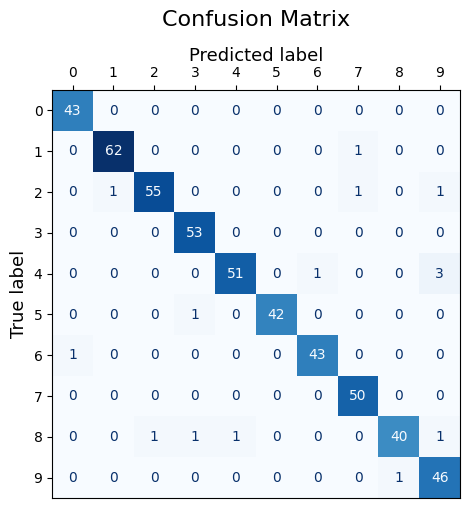

In [65]:
show_conf_matrix(lab_test, predict_labels, range(NB_CLASS), figsize=(7,6))

## 6 - Autres ressources intéressantes... des vidéos :

In [32]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [33]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [34]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [35]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>